### Modelling


### Imports

In [42]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [17]:
# The data, split between train and test sets:
x_train = np.load('X_train.npy')
x_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [18]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [19]:
class Metrics(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

In [20]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_11 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 15, 15, 64)       

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size= 0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size= 0.3, random_state=42)

In [24]:
f1_metrics = Metrics(val_data= (X_val, y_val))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_data=(X_val, y_val),
    shuffle=True
)


Epoch 1/30
2148/2148 [==============================] - 229s 106ms/step - loss: 0.7474 - accuracy: 0.7693 - val_loss: 0.5415 - val_accuracy: 0.8194
Epoch 2/30
   1/2148 [..............................] - ETA: 0s - loss: 0.6362 - accuracy: 0.8281

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


2148/2148 [==============================] - 230s 107ms/step - loss: 0.5380 - accuracy: 0.8251 - val_loss: 0.4661 - val_accuracy: 0.8470


/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/30
2148/2148 [==============================] - 222s 104ms/step - loss: 0.4734 - accuracy: 0.8444 - val_loss: 0.4003 - val_accuracy: 0.8694
Epoch 4/30
2148/2148 [==============================] - 218s 101ms/step - loss: 0.4325 - accuracy: 0.8572 - val_loss: 0.3724 - val_accuracy: 0.8759
Epoch 5/30
2148/2148 [==============================] - 221s 103ms/step - loss: 0.4055 - accuracy: 0.8655 - val_loss: 0.3471 - val_accuracy: 0.8866
Epoch 6/30
2148/2148 [==============================] - 227s 106ms/step - loss: 0.3830 - accuracy: 0.8723 - val_loss: 0.3294 - val_accuracy: 0.8909
Epoch 7/30
2148/2148 [==============================] - 237s 110ms/step - loss: 0.3659 - accuracy: 0.8776 - val_loss: 0.3197 - val_accuracy: 0.8964
Epoch 8/30
2148/2148 [==============================] - 236s 110ms/step - loss: 0.3506 - accuracy: 0.8817 - val_loss: 0.3135 - val_accuracy: 0.8969
Epoch 9/30
2148/2148 [==============================] - 240s 112ms/step - loss: 0.3395 - accuracy: 0.8850 - val_

In [25]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /Users/davidcarricondo/Documents/NN_r_workshop/models/keras_cnn_model.h5 


<AxesSubplot:>

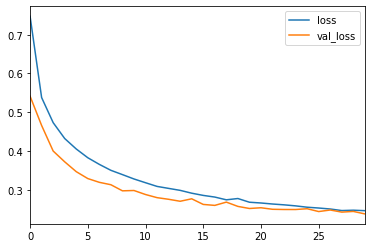

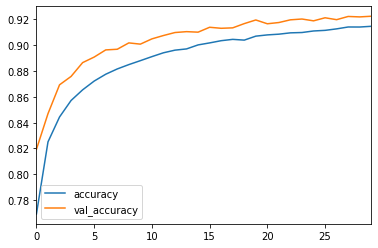

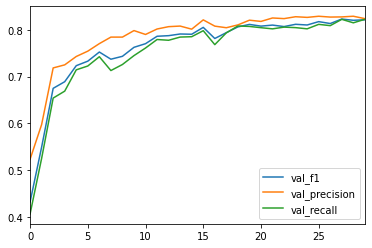

In [26]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()


#### Reload model and predictions

In [5]:
model = keras.models.load_model('models/keras_cnn_model.h5')

In [27]:
y_pred = model.predict(X_test)


In [28]:
y_pred

array([[1.0000000e+00, 2.9529835e-17, 3.0484852e-19, ..., 1.6392779e-21,
        3.2474056e-30, 0.0000000e+00],
       [1.0000000e+00, 9.8582986e-10, 6.2877190e-11, ..., 1.6708538e-14,
        5.0254945e-17, 0.0000000e+00],
       [3.2689726e-01, 8.1228048e-02, 4.2078089e-05, ..., 4.0591389e-04,
        2.0910983e-03, 3.6383241e-10],
       ...,
       [8.8042086e-03, 1.3429289e-04, 7.3251264e-05, ..., 4.2606884e-04,
        1.7231430e-01, 3.7906435e-11],
       [1.0000000e+00, 1.6555733e-21, 3.3218321e-21, ..., 5.2801923e-24,
        3.5171134e-38, 0.0000000e+00],
       [9.9427730e-01, 7.9357371e-05, 1.1085370e-03, ..., 1.7586357e-05,
        6.2353889e-10, 1.4943376e-13]], dtype=float32)

In [36]:
predictions = [x.argmax() for x in y_pred]

In [37]:
real = [x.argmax() for x in y_test]

In [64]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}


In [67]:
pred = [classes_wild[x] for x in predictions]
true = [classes_wild[x] for x in real]

<AxesSubplot:>

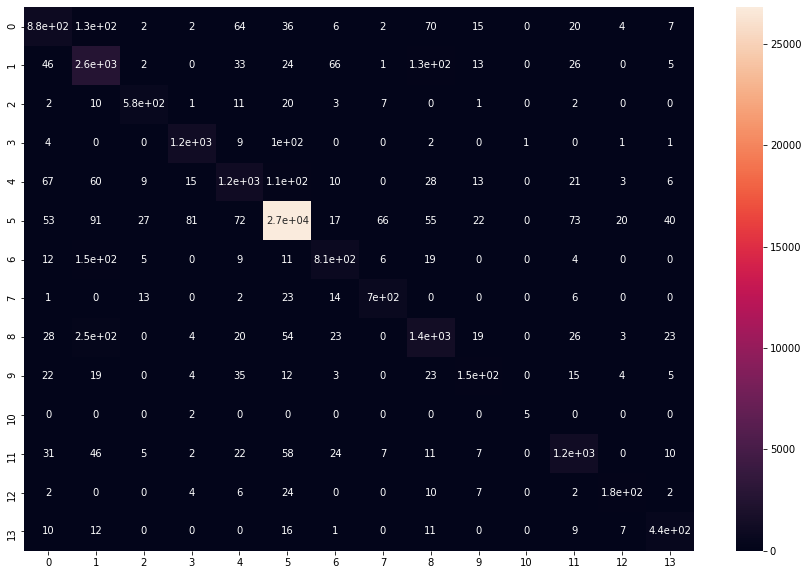

In [71]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_true=true, y_pred=pred), annot=True, ax=ax)
